In [1]:
from ase.build import bulk
from ase.io import lammpsdata
from ase.calculators.lammpslib import LAMMPSlib
from kaldo.forceconstants import ForceConstants
from kaldo.conductivity import Conductivity
from kaldo.phonons import Phonons
from pylab import *
from ase.io import read,write
import subprocess

import kaldo.controllers.plotter as plotter
import matplotlib
import numpy as np
import warnings
warnings.filterwarnings("ignore")

2024-10-17 17:52:44.486987: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 17:52:44.488150: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 17:52:44.491806: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 17:52:44.502520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 17:52:44.519842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
def cumulative_cond_cal(freq,full_cond,n_phonons):

  conductivity = np.einsum('maa->m', 1/3 * full_cond)
  conductivity = conductivity.reshape(n_phonons)
  cumulative_cond = np.zeros_like(conductivity)
  freq_reshaped = freq.reshape(n_phonons)

  for mu in range(cumulative_cond.size):
      single_cumulative_cond = conductivity[(freq_reshaped < freq_reshaped[mu])].sum()
      cumulative_cond[mu] = single_cumulative_cond

  return cumulative_cond

In [3]:
def cumulative_cond_cal(observables, kappa_tensor, prefactor=1/3):

    """Compute cumulative conductivity based on either frequnecy or mean-free path

       input:
       observables: (ndarray) either phonon frequnecy or mean-free path
       cond_tensor: (ndarray) conductivity tensor
       prefactor: (float) prefactor to average kappa tensor, 1/3 for bulk material

       ouput:
       observeables: (ndarray) sorted phonon frequency or mean-free path
       kappa_cond (ndarray) cumulative conductivity

    """

    # Sum over kappa by directions
    kappa = np.einsum('maa->m', prefactor * kappa_tensor)

    # Sort observables
    observables_argsort_indices = np.argsort(observables)
    cumulative_kappa = np.cumsum(kappa[observables_argsort_indices])
    return observables[observables_argsort_indices], cumulative_kappa

def set_fig_properties(ax_list, panel_color_str='black', line_width=2):
    tl = 4
    tw = 2
    tlm = 2

    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in',
                       right=True, top=True)
        ax.spines['bottom'].set_color(panel_color_str)
        ax.spines['top'].set_color(panel_color_str)
        ax.spines['left'].set_color(panel_color_str)
        ax.spines['right'].set_color(panel_color_str)

        ax.spines['bottom'].set_linewidth(line_width)
        ax.spines['top'].set_linewidth(line_width)
        ax.spines['left'].set_linewidth(line_width)
        ax.spines['right'].set_linewidth(line_width)

        for t in ax.xaxis.get_ticklines(): t.set_color(panel_color_str)
        for t in ax.yaxis.get_ticklines(): t.set_color(panel_color_str)
        for t in ax.xaxis.get_ticklines(): t.set_linewidth(line_width)
        for t in ax.yaxis.get_ticklines(): t.set_linewidth(line_width)

In [4]:
atom_type={}

for i in range(1,17):
    atom_type[i] = 6
for i in range(17,27):
    atom_type[i] = 1
for i in range(27,31):
    atom_type[i] = 16

In [5]:
atom_type

{1: 6,
 2: 6,
 3: 6,
 4: 6,
 5: 6,
 6: 6,
 7: 6,
 8: 6,
 9: 6,
 10: 6,
 11: 6,
 12: 6,
 13: 6,
 14: 6,
 15: 6,
 16: 6,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 16,
 28: 16,
 29: 16,
 30: 16}

In [6]:
atoms=lammpsdata.read_lammps_data('T4_relaxed.lammps',Z_of_type=atom_type,sort_by_id='True',units = 'real',style = 'full')

In [7]:
b1 = atoms.get_reciprocal_cell()[:,0]
b2 = atoms.get_reciprocal_cell()[:,1]
b3 = atoms.get_reciprocal_cell()[:,2]

b1_length = np.linalg.norm(b1)
b2_length = np.linalg.norm(b2)
b3_length = np.linalg.norm(b3)
    
# Calculate the number of divisions along each direction
# N1 = 3
# N2 = 4
# N3 = 2

# res1 = b1_length/N1
# res2 = b2_length/N2
# res3 = b3_length/N3

# print(res1,res2,res3)

res = 0.03
N1 = b1_length/res
N2 = b2_length/res
N3 = b3_length/res

print(np.round(N1),np.round(N2),np.round(N3))

4.0 6.0 2.0


In [8]:
nrep = 3
supercell = np.array([nrep, nrep, 1])

write('replicated_atoms.xyz',format ='extxyz',images=atoms.copy().repeat(supercell))

# Print reminder information
print('Supercell structures and LAMMPS input generated.') 
print('Supercell dimension is: ' + str(supercell))

Supercell structures and LAMMPS input generated.
Supercell dimension is: [3 3 1]


In [9]:
forceconstants = ForceConstants.from_folder(folder='./',supercell=supercell,format='lammps')

2024-10-17 17:52:46,588 - kaldo - INFO - Reading dynamical matrix
2024-10-17 17:52:46,957 - kaldo - INFO - Reading sparse third order
2024-10-17 17:52:48,519 - kaldo - INFO - reading third order: 0.0%
2024-10-17 17:53:12,567 - kaldo - INFO - reading third order: 4.0%
2024-10-17 17:53:37,670 - kaldo - INFO - reading third order: 7.000000000000001%
2024-10-17 17:54:02,852 - kaldo - INFO - reading third order: 11.0%
2024-10-17 17:54:28,058 - kaldo - INFO - reading third order: 15.0%
2024-10-17 17:54:53,357 - kaldo - INFO - reading third order: 18.0%
2024-10-17 17:55:18,569 - kaldo - INFO - reading third order: 22.0%
2024-10-17 17:55:43,794 - kaldo - INFO - reading third order: 26.0%
2024-10-17 17:56:08,896 - kaldo - INFO - reading third order: 28.999999999999996%
2024-10-17 17:56:34,053 - kaldo - INFO - reading third order: 33.0%
2024-10-17 17:56:59,290 - kaldo - INFO - reading third order: 37.0%
2024-10-17 17:57:24,520 - kaldo - INFO - reading third order: 40.0%
2024-10-17 17:57:49,725 -

In [10]:
kx = int(np.round(N1))
ky = int(np.round(N2))
kz = int(np.round(N3))
kpts = [kx, ky, kz]
temperature = 10
is_classic = False
k_label = str(kx) + '_' + str(ky) + '_' + str(kz)
folder='dynmat-' + k_label
# Create a phonon object
phonons = Phonons(forceconstants=forceconstants,
                kpts=kpts,
                is_classic=is_classic,
                temperature=temperature,
                folder=folder,
                # is_unfolding=True,  
                storage='numpy')

2024-10-17 18:02:39,600 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/_eigensystem


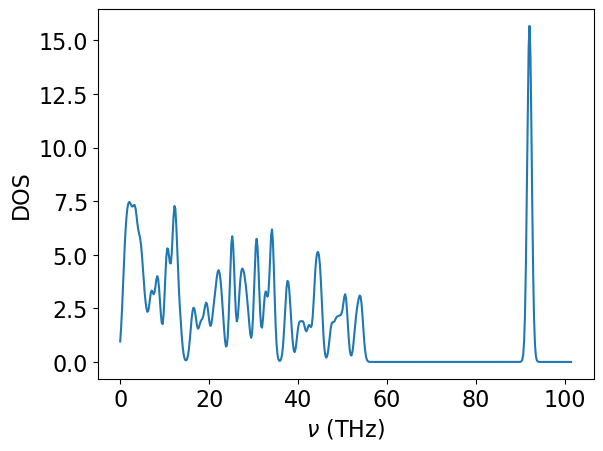

In [11]:
plotter.plot_dos(phonons,bandwidth=0.25,n_points=500)

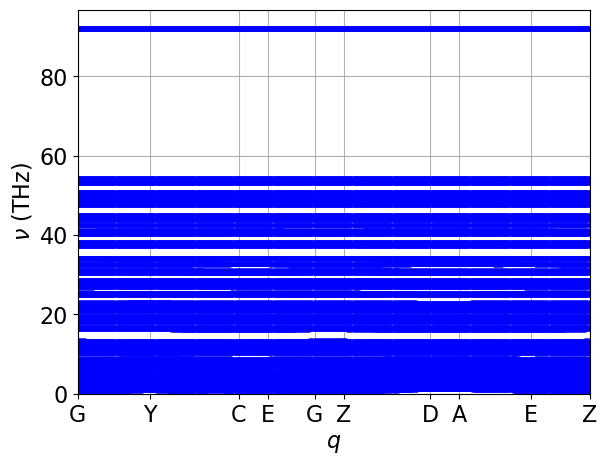

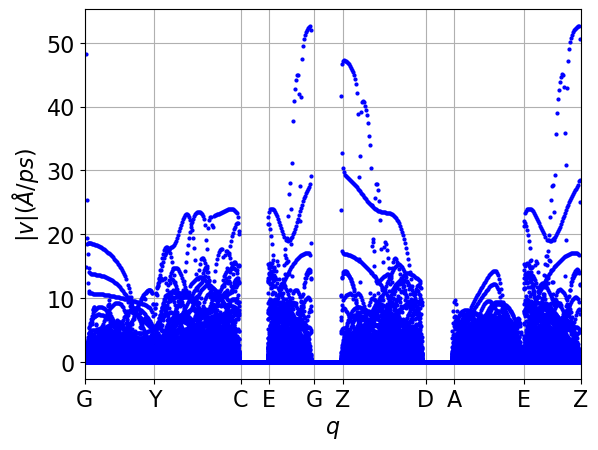

In [12]:
# Plot dispersion relation and group velocity in each direction
kpath=atoms.cell.bandpath(path='GYCEGZDAEZ',npoints=500,special_points={'G': [0,0,0], 'Y': [0,0.5,0], 'Z': [0,0,0.5], 'A': [-0.5,0.5,0], 'E': [-0.5,0,0], 'C': [-0.5,0,0.5], 'D': [-0.5,0.5,0.5], 'H': [0,0.5,0.5]})
plotter.plot_dispersion(phonons,manually_defined_path=kpath)
# plotter.plot_dispersion(phonons,n_k_points=200)
print('\n')

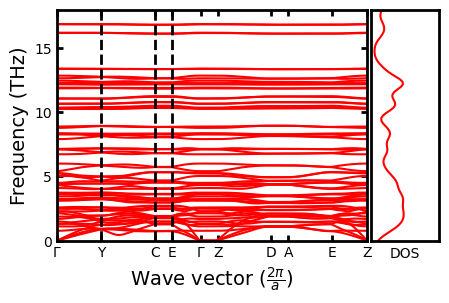

In [13]:
# Denote data path
data_folder = "./"

# Derive symbols for high symmetry directions in Brillouin zone
dispersion = np.loadtxt(data_folder  + 'plots/'+k_label+'/dispersion')
point_names = np.loadtxt(data_folder  + 'plots/'+k_label+'/point_names', dtype=str)

point_names_list = []
for point_name in point_names:
    if point_name == 'G':
        point_name = r'$\Gamma$'
    elif point_name == 'U':
        point_name = 'U=K'
    point_names_list.append(point_name)

# Load in the "tick-mark" values for these symbols
q = np.loadtxt(data_folder  + 'plots/'+k_label+'/q')
Q = np.loadtxt(data_folder  + 'plots/'+k_label+'/Q_val')
dos_Si = np.load(data_folder + 'plots/'+k_label+'/dos.npy')

fig = plt.figure(figsize=(4,3))
set_fig_properties([gca()])
plot(q[0], dispersion[0, 0], 'r-', ms=1)
plot(q, dispersion, 'r-', ms=1)
for i in range(1, 4):
    axvline(x=Q[i], ymin=0, ymax=2, ls='--',  lw=2, c="k")
ylabel('Frequency (THz)', fontsize=14)
xlabel(r'Wave vector ($\frac{2\pi}{a}$)', fontsize=14)
gca().set_yticks(np.arange(0, 30, 5))
xticks(Q, point_names_list)
ylim([0, 18])
xlim([Q[0], Q[-1]])
dosax = fig.add_axes([0.91, .11, .17, .77])
set_fig_properties([gca()])
for d in np.expand_dims(dos_Si[1],0):
    dosax.plot(d, dos_Si[0],c='r')
dosax.set_yticks([])
dosax.set_xticks([])
dosax.set_xlabel("DOS")
ylim([0, 18])
show()

2024-10-17 18:03:17,036 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/frequency
2024-10-17 18:03:17,038 - kaldo - INFO - dynmat-4_6_2/4_6_2/10/quantum/heat_capacity not found in numpy format, calculating heat_capacity
2024-10-17 18:03:17,459 - kaldo - INFO - dynmat-4_6_2/4_6_2/10/quantum/heat_capacity stored
2024-10-17 18:03:17,462 - kaldo - INFO - dynmat-4_6_2/4_6_2/10/quantum/bandwidth not found in numpy format, calculating bandwidth
2024-10-17 18:03:17,463 - kaldo - INFO - dynmat-4_6_2/4_6_2/10/quantum/anharmonic_bandwidth not found in numpy format, calculating anharmonic_bandwidth
2024-10-17 18:03:17,464 - kaldo - INFO - dynmat-4_6_2/4_6_2/10/quantum/_ps_and_gamma not found in numpy format, calculating _ps_and_gamma
2024-10-17 18:03:20,682 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/_eigensystem
2024-10-17 18:03:20,718 - kaldo - INFO - Projection started
2024-10-17 18:03:20,719 - kaldo - INFO - dynmat-4_6_2/4_6_2/10/quantum/population not found in numpy format, calculating population

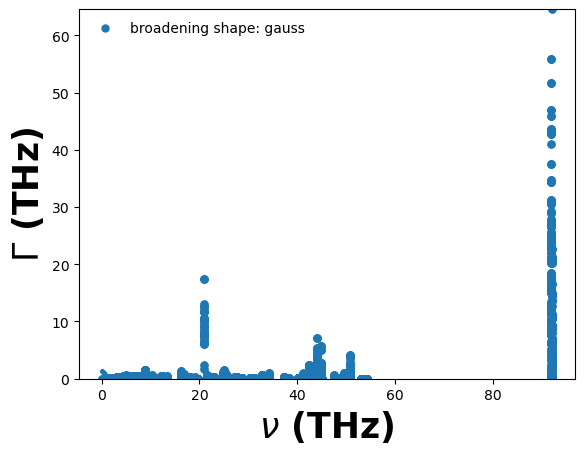

2024-10-17 19:46:40,372 - kaldo - INFO - dynmat-4_6_2/4_6_2/10/quantum/phase_space not found in numpy format, calculating phase_space
2024-10-17 19:46:40,373 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/10/quantum/_ps_and_gamma
2024-10-17 19:46:40,376 - kaldo - INFO - dynmat-4_6_2/4_6_2/10/quantum/phase_space stored




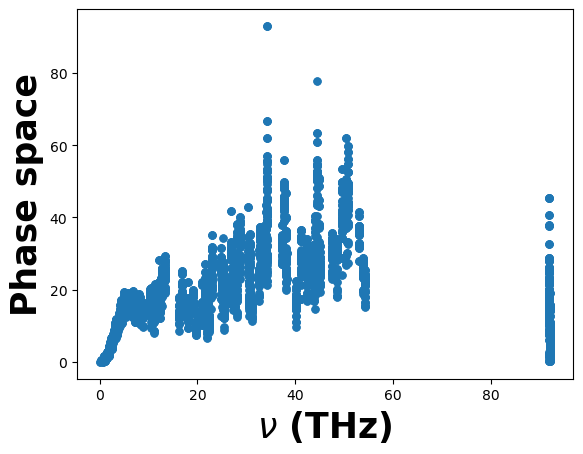

In [14]:
frequency = phonons.frequency.flatten(order='C')
heat_capacity = phonons.heat_capacity.flatten(order='C')
bandwidth = phonons.bandwidth.flatten(order='C')

plt.figure()
plt.scatter(frequency[3:], 1e23 * heat_capacity[3:], s=5)  # Get rid of the first three non-physical modes while plotting
plt.xlabel("$\\nu$ (THz)", fontsize=16)
plt.ylabel(r"$C_{v} \ (10^{23} \ J/K)$", fontsize=16)

# Plot phonon bandwidth vs frequency
print('\n')
plt.plot(frequency[3:],bandwidth[3:],'.',markersize=10,label= 'broadening shape: ' + str(phonons.broadening_shape))
plt.ylabel('$\Gamma$ (THz)', fontsize=25, fontweight='bold')
plt.xlabel("$\\nu$ (THz)", fontsize=25, fontweight='bold')
plt.ylim([bandwidth.min(), bandwidth.max()])
plt.legend(loc=2,frameon = False)
plt.show()

phase_space = phonons.phase_space.flatten(order='C')

# Plot phase space vs frequency
print('\n')
plt.figure()
plt.plot(frequency[3:], phase_space[3:], '.', markersize=10)
plt.ylabel ("Phase space", fontsize=25, fontweight='bold')
plt.xlabel("$\\nu$ (THz)", fontsize=25, fontweight='bold')
plt.show()

2024-10-17 19:46:40,572 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/frequency
2024-10-17 19:46:40,574 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/10/quantum/bandwidth
2024-10-17 19:46:40,575 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/participation_ratio




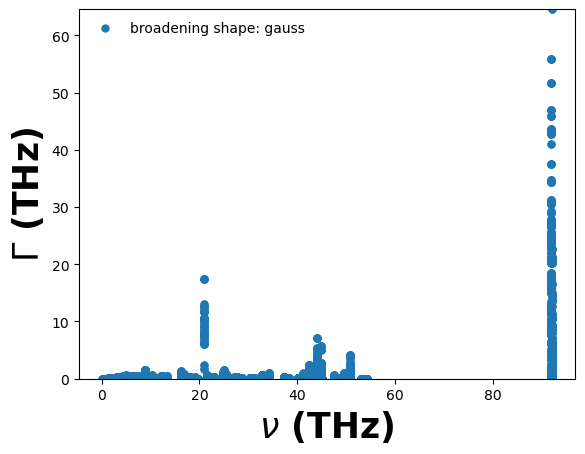

2024-10-17 19:46:40,779 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/10/quantum/phase_space




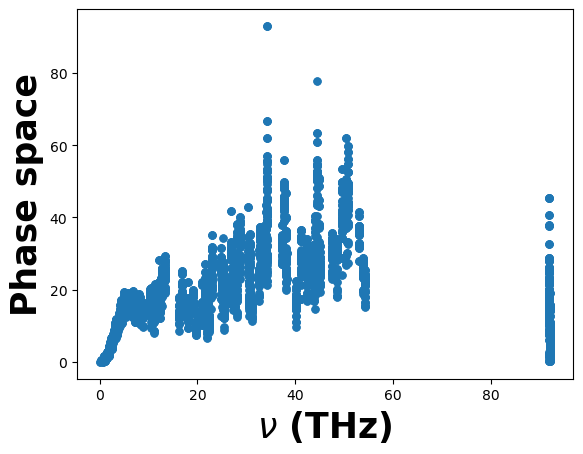

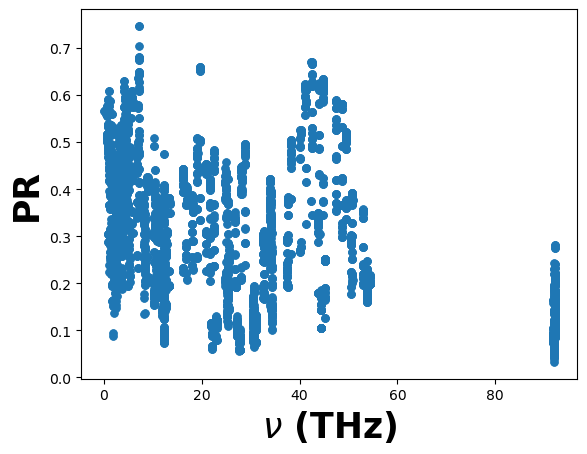

In [15]:
# Direct access to properties
# calculated during the simulation
frequency = phonons.frequency.flatten(order='C')
bandwidth = phonons.bandwidth.flatten(order='C')
participation = phonons.participation_ratio.flatten(order='C')

# Plot phonon bandwidth vs frequency
print('\n')
plt.plot(frequency[3:],bandwidth[3:],'.',markersize=10,label= 'broadening shape: ' + str(phonons.broadening_shape))
plt.ylabel('$\Gamma$ (THz)', fontsize=25, fontweight='bold')
plt.xlabel("$\\nu$ (THz)", fontsize=25, fontweight='bold')
plt.ylim([bandwidth.min(), bandwidth.max()])
plt.legend(loc=2,frameon = False)
plt.show()

phase_space = phonons.phase_space.flatten(order='C')

# Plot phase space vs frequency
print('\n')
plt.figure()
plt.plot(frequency[3:], phase_space[3:], '.', markersize=10)
plt.ylabel ("Phase space", fontsize=25, fontweight='bold')
plt.xlabel("$\\nu$ (THz)", fontsize=25, fontweight='bold')
plt.show()

 # Plot phase space vs frequency
print('\n')
plt.figure()
plt.plot(frequency[3:], participation[3:], '.', markersize=10)
plt.ylabel ("PR", fontsize=25, fontweight='bold')
plt.xlabel("$\\nu$ (THz)", fontsize=25, fontweight='bold')
plt.show()


In [16]:
from kaldo.conductivity import Conductivity

# Calculate conductivity  with direct inversion approach (inverse)
print('\n')
inv_cond_matrix = (Conductivity(phonons=phonons, method='inverse').conductivity.sum(axis=0))
print('Inverse conductivity (W/mK): %.3f'%(np.mean(np.diag(inv_cond_matrix))))
print(inv_cond_matrix)

# Calculate conductivity  with  relaxation time approximation (rta)
print('\n')
rta_cond_matrix = Conductivity(phonons=phonons, method='rta').conductivity.sum(axis=0)
print('Rta conductivity (W/mK): %.3f'%(np.mean(np.diag(rta_cond_matrix))))
print(rta_cond_matrix)
# Calculate conductivity  with  self-consistent approach (sc)

print('\n')
sc_cond_matrix = Conductivity(phonons=phonons, method='sc',n_iterations=20).conductivity.sum(axis=0)
print('Self-consistent conductivity (W/mK): %.3f'%(np.mean(np.diag(sc_cond_matrix))))
print(sc_cond_matrix)



2024-10-17 19:46:41,173 - kaldo - INFO - dynmat-4_6_2/4_6_2/10/quantum/inverse/conductivity not found in formatted format, calculating conductivity
2024-10-17 19:46:41,175 - kaldo - INFO - dynmat-4_6_2/4_6_2/10/quantum/inverse/mean_free_path not found in formatted format, calculating mean_free_path
2024-10-17 19:46:41,177 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/physical_mode
2024-10-17 19:46:41,178 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/velocity
2024-10-17 19:46:41,179 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/physical_mode
2024-10-17 19:46:41,181 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/frequency
2024-10-17 19:46:41,182 - kaldo - INFO - dynmat-4_6_2/4_6_2/10/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor
2024-10-17 19:46:44,623 - kaldo - INFO - Loading dynmat-4_6_2/4_6_2/_eigensystem
2024-10-17 19:46:44,662 - kaldo - INFO - scattering_tensor: [8640 8642] * <class 'float'>
2024-10-17 19:46:44,663 - kaldo - INFO - Mem

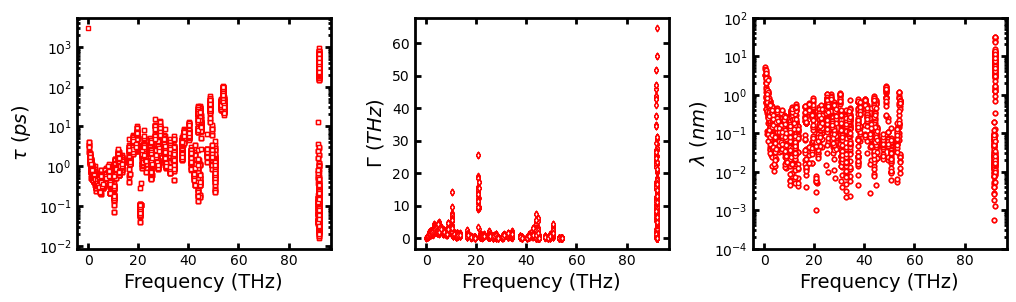

In [17]:
# Load in scattering rate
scattering_rate = np.load(
    data_folder +
    folder+'/'+k_label+'/300/quantum/bandwidth.npy', allow_pickle=True)

# Derive lifetime, which is inverse of scattering rate
life_time = scattering_rate ** (-1)

# Denote lists to intake mean free path in each direction
mean_free_path = []
for i in range(3):
    mean_free_path.append(np.loadtxt(
    data_folder +
    folder+'/'+k_label+'/300/quantum/inverse/mean_free_path_' +
    str(i) + '.dat'))

# Convert list to numpy array and compute norm for mean free path
# Convert the unit from angstrom  to nanometer
mean_free_path = np.array(mean_free_path).T
mean_free_path_norm = np.linalg.norm(
    mean_free_path.reshape(-1, 3), axis=1) / 10.0

# Plot observables in subplot
figure(figsize=(12, 3))
subplot(1,3, 1)
set_fig_properties([gca()])
scatter(frequency.flatten(order='C'),
        life_time, facecolor='w', edgecolor='r', s=10, marker='s')
yscale('log')
ylabel(r'$\tau \ (ps)$', fontsize=14)
xlabel('Frequency (THz)', fontsize=14)

subplot(1,3, 2)
set_fig_properties([gca()])
scatter(frequency.flatten(order='C'),
        scattering_rate, facecolor='w', edgecolor='r', s=10, marker='d')
ylabel(r'$\Gamma \ (THz)$', fontsize=14)
xlabel('Frequency (THz)', fontsize=14)

subplot(1,3, 3)
set_fig_properties([gca()])
scatter(frequency.flatten(order='C'),
        mean_free_path_norm, facecolor='w', edgecolor='r', s=10, marker='8')
ylabel(r'$\lambda \ (nm)$', fontsize=14)
xlabel('Frequency (THz)', fontsize=14)
yscale('log')
ylim([1e-4, 1e2])
subplots_adjust(wspace=0.33)
show()

Bulk thermal conductivity: 0.1 W m^-1 K^-1

kappa matrix: 
[[ 2.12923734e-01 -3.14610871e-03  3.37020750e-06]
 [-3.38640495e-03  7.82814316e-02 -5.63911614e-07]
 [ 3.04043756e-06 -5.27099001e-07  2.21959039e-09]]




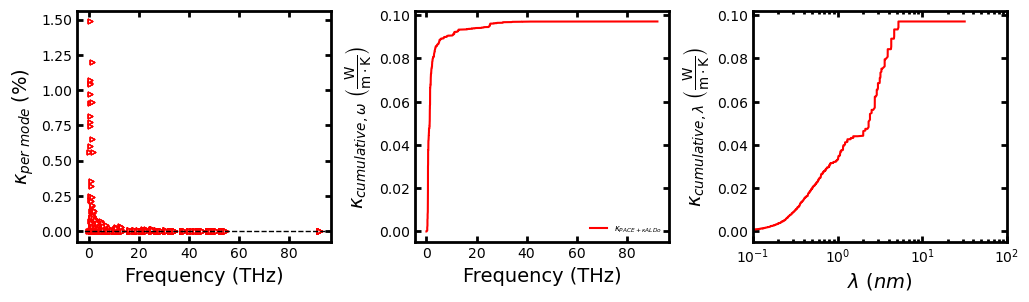

In [18]:
# Denote zeros to intake kappa tensor
kappa_tensor = np.zeros([mean_free_path.shape[0], 3, 3])
for i in range(3):
    for j in range(3):
        kappa_tensor[:, i, j] = np.loadtxt(data_folder +
    folder+'/'+k_label+'/300/quantum/inverse/conductivity_' +
    str(i) + '_' + str(j) + '.dat')

# Sum over the 0th dimension to recover 3-by-3 kappa matrix
kappa_matrix = kappa_tensor.sum(axis=0)
print("Bulk thermal conductivity: %.1f W m^-1 K^-1\n"
      %np.mean(np.diag(kappa_matrix)))
print("kappa matrix: ")
print(kappa_matrix)
print('\n')

# Compute kappa in per mode and cumulative representations
kappa_per_mode = kappa_tensor.sum(axis=-1).sum(axis=1)
freq_sorted, kappa_cum_wrt_freq = cumulative_cond_cal(
    frequency.flatten(order='C'), kappa_tensor)
lambda_sorted, kappa_cum_wrt_lambda = cumulative_cond_cal(
    mean_free_path_norm, kappa_tensor)

# Plot observables in subplot
figure(figsize=(12, 3))
subplot(1,3, 1)
set_fig_properties([gca()])
scatter(frequency.flatten(order='C'),
        100*kappa_per_mode/np.sum(kappa_per_mode), facecolor='w', edgecolor='r', s=10, marker='>')
gca().axhline(y = 0, color='k', ls='--', lw=1)
# ylabel(r'$\kappa_{per \ mode}\;\left(\frac{\rm{W}}{\rm{m}\cdot\rm{K}}\right)$',fontsize=14)
ylabel(r'$\kappa_{per \ mode}\;\left(\%\right)$',fontsize=14)
xlabel('Frequency (THz)', fontsize=14)
# ylim([-0.5, 6])

subplot(1,3, 2)
set_fig_properties([gca()])
# gca().axhline(y = 147, color='b', ls='--', lw=2,  label=r'$\kappa_{LDA + BTE} \approx 147 \ W \ m^{-1} \ K^{-1} $')
# gca().axhline(y = 145, color='c', ls='--', lw=2,  label=r'$\kappa_{PBE + BTE} \approx 145 \ W \ m^{-1} \ K^{-1} $')
plot(freq_sorted, kappa_cum_wrt_freq, 'r',
     label=r'$\kappa_{PACE + \kappa ALDo}$')
# fill_between(freq_sorted, 130, 160, color='0.5',alpha=0.2,
#              label=r'$\kappa_{exp}$')
ylabel(r'$\kappa_{cumulative, \omega}\;\left(\frac{\rm{W}}{\rm{m}\cdot\rm{K}}\right)$',fontsize=14)
xlabel('Frequency (THz)', fontsize=14)
legend(loc=4, frameon=False, fontsize=6)

subplot(1,3, 3)
set_fig_properties([gca()])
plot(lambda_sorted, kappa_cum_wrt_lambda, 'r')
xlabel(r'$\lambda \ (nm)$', fontsize=14)
ylabel(r'$\kappa_{cumulative, \lambda}\;\left(\frac{\rm{W}}{\rm{m}\cdot\rm{K}}\right)$',fontsize=14)
xscale('log')
xlim(0.1,1e2)
subplots_adjust(wspace=0.33)
show()

In [19]:
kappa_per_mode.shape

(8640,)

NameError: name 'cv' is not defined